# Import Libraries

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

## Prepare files

In [2]:
url_housing = (
    "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
)
data_dir = Path.cwd().parent / "data"
csv_data = data_dir / "housing.csv"

data_dir.mkdir(exist_ok=True)

with requests.Session() as s:
    r = s.get(url_housing)

with csv_data.open("wb") as f:
    f.write(r.content)

## EDA

In [3]:
df = pd.read_csv(csv_data)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


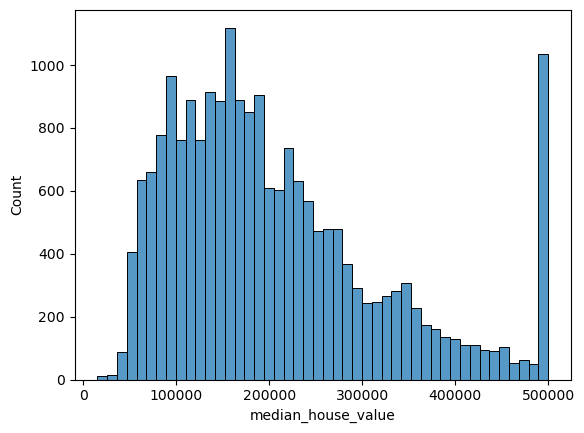

In [4]:
sns.histplot(df["median_house_value"])

plt.show()

No. It's positively skewed, but we can't really call it a long tail distribution

## Preparing the dataset

In [5]:
df_ori = df.copy()

In [6]:
cols = [
    "latitude",
    "longitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value"
]

df = df[df["ocean_proximity"].isin(["<1H OCEAN", "INLAND"])].loc[:, cols]

In [7]:
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


## Question 1

In [8]:
df.isna().any()

latitude              False
longitude             False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
dtype: bool

`total_bedrooms`

## Question 2

In [9]:
df["population"].median()

1195.0

## Splitting the Dataset

In [10]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.shuffle(idx)

In [11]:
df_shuffled = df.iloc[idx]

# split the data
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[-n_test:].copy()


# apply log transformation to target
y_train = np.log1p(df_train["median_house_value"].to_numpy())
y_val = np.log1p(df_val["median_house_value"].to_numpy())
y_test = np.log1p(df_test["median_house_value"].to_numpy())

In [12]:
df_train.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
19963,36.23,-119.14,22.0,2935.0,523.0,1927.0,530.0,2.5875,70400.0
5929,34.12,-117.79,16.0,2426.0,426.0,1319.0,446.0,4.8125,224500.0
11377,33.68,-117.97,26.0,3653.0,568.0,1930.0,585.0,5.7301,260900.0
6443,34.10,-118.03,32.0,2668.0,609.0,1512.0,541.0,2.9422,233100.0
17546,37.34,-121.87,39.0,2479.0,541.0,1990.0,506.0,2.4306,289100.0


/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


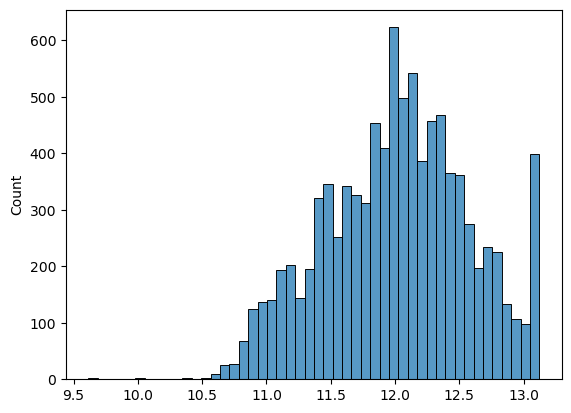

In [13]:
sns.histplot(y_train)

plt.show()

## Question 3

In [14]:
base = cols[:-1]

def prepare_X_zero(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.to_numpy()
    return X

def prepare_X_mean(df):
    df_num = df[base]
    df_num = df_num.fillna(df_num.mean())
    X = df_num.to_numpy()
    return X

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ X.T @ y

    return w[0], w[1:]

In [15]:
X_train_zero = prepare_X_zero(df_train)
X_train_mean = prepare_X_mean(df_train)

w0_zero, w_zero = train_linear_regression(X_train_zero, y_train)
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

y_pred_zero = w0_zero + X_train_zero @ w_zero
y_pred_mean = w0_mean + X_train_mean @ w_mean

/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikki/workspace/machine-learning-zoomcamp/.conda_env/lib/python3.11/site-packages

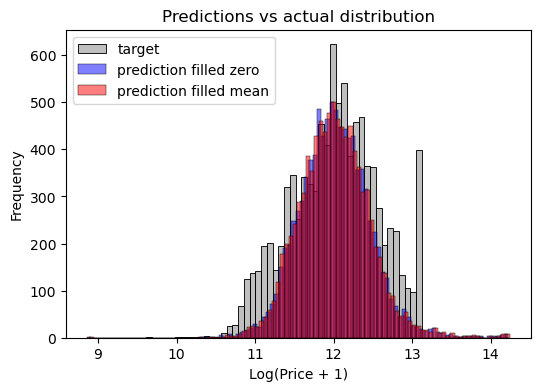

In [16]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='grey', alpha=0.5)
sns.histplot(y_pred_zero, label='prediction filled zero', color='blue', alpha=0.5)
sns.histplot(y_pred_mean, label='prediction filled mean', color='red', alpha=0.5)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [17]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [18]:
X_val_zero = prepare_X_zero(df_val)
X_val_mean = prepare_X_mean(df_val)

y_pred_zero = w0_zero + X_val_zero @ w_zero
y_pred_mean = w0_mean + X_val_mean @ w_mean

In [19]:
rmse_score_zero = rmse(y_val, y_pred_zero)
rmse_score_mean = rmse(y_val, y_pred_mean)

print(round(rmse_score_zero, 2))
print(round(rmse_score_mean, 2))

0.34
0.34


`Both are equally good`

## Question 4

In [20]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T @ X
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ X.T @ y
    
    return w[0], w[1:]

In [21]:
r_list = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
rmse_score_list = []
X_train_zero = prepare_X_zero(df_train)

for r in r_list:
    w0_zero, w_zero = train_linear_regression_reg(X_train_zero, y_train, r)

    X_val_zero = prepare_X_zero(df_val)
    y_pred_zero = w0_zero + X_val_zero @ w_zero

    rmse_score_zero = rmse(y_val, y_pred_zero)

    print(r, w0_zero, round(rmse_score_zero, 2))

    rmse_score_list.append(round(rmse_score_zero, 2))

0 -9.763249477872478 0.34
1e-06 -9.763228830761964 0.34
0.0001 -9.761185235634128 0.34
0.001 -9.742646249295081 0.34
0.01 -9.56105619328998 0.34
0.1 -8.058889769412012 0.34
1 -3.1331542783180195 0.34
5 -0.84108679750481 0.35
10 -0.43811723158933275 0.35


## Question 5

In [22]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test

rmse_score_list = []

for seed in range(10):
    np.random.seed(seed)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    # split the data
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[-n_test:].copy()

    # apply log transformation to target
    y_train = np.log1p(df_train["median_house_value"].to_numpy())
    y_val = np.log1p(df_val["median_house_value"].to_numpy())
    y_test = np.log1p(df_test["median_house_value"].to_numpy())

    # train the dataset
    X_train_zero = prepare_X_zero(df_train)
    w0_zero, w_zero = train_linear_regression(X_train_zero, y_train)

    X_val_zero = prepare_X_zero(df_val)
    y_pred_zero = w0_zero + X_val_zero @ w_zero

    rmse_score_zero = rmse(y_val, y_pred_zero)
    print(seed, w0_zero, round(rmse_score_zero, 2))
    rmse_score_list.append(round(rmse_score_zero, 2))

std_rmse_scores = np.std(rmse_score_list)
print("The value of std is:", round(std_rmse_scores, 3))

0 -9.87006897148552 0.34
1 -9.114011209478683 0.34
2 -9.911560201405122 0.34
3 -10.233183681940078 0.33
4 -9.1747634505935 0.34
5 -10.006648303263274 0.34
6 -10.039903099139199 0.34
7 -10.35354544522589 0.35
8 -9.899416167009921 0.35
9 -9.96462212626483 0.33
The value of std is: 0.006


## Question 6

In [23]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test

r = 0.001
np.random.seed(9)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

# split the data
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[-n_test:].copy()

# apply log transformation to target
y_train = np.log1p(df_train["median_house_value"].to_numpy())
y_val = np.log1p(df_val["median_house_value"].to_numpy())
y_test = np.log1p(df_test["median_house_value"].to_numpy())

# combine train and validation datasets
df_full_train = pd.concat([df_train, df_val], axis=0).reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val], axis=0)

# train the dataset
X_full_train = prepare_X_zero(df_full_train)
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r)

X_test = prepare_X_zero(df_test)
y_pred = w0 + X_test @ w

rmse_score = rmse(y_test, y_pred)
print(r, w0, round(rmse_score, 2))

print("The RMSE is:", round(rmse_score, 2))

0.001 -9.72483921716023 0.33
The RMSE is: 0.33
